# Network Analysis with BigQuery
## Bachelor Thesis Data Analysis

This notebook contains templates and utilities for analyzing social network data stored in BigQuery.

In [42]:
# Enable inline plotting
%matplotlib inline

In [43]:
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/calvindudek/projects/sophie/twitter-analysis-python/.secrets/service-account.json'

creds_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
print(f"Current credentials path: {creds_path}")

Current credentials path: /Users/calvindudek/projects/sophie/twitter-analysis-python/.secrets/service-account.json


## 1. Setup and Configuration

Import libraries and set up BigQuery connections.

In [44]:
# Data handling and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# BigQuery
from google.cloud import bigquery
from google.cloud.exceptions import GoogleCloudError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# Define colors
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
sns.set_palette(sns.color_palette(colors))

In [45]:
# BigQuery configuration
project_id = "grounded-nebula-408412"
dataset = "python_src"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

## 2. BigQuery Utilities

This section includes utility functions for working with BigQuery:
- List all tables in the dataset
- Retrieve the schema of a specific table

In [46]:
def list_tables():
    """List all tables in the dataset."""
    try:
        dataset_ref = client.dataset(dataset)
        tables = list(client.list_tables(dataset_ref))
        table_names = [table.table_id for table in tables]
        print("Tables in dataset:")
        for table in table_names:
            print(f"- {table}")
    except GoogleCloudError as e:
        print(f"Error listing tables: {str(e)}")

In [47]:
def get_table_schema(table_id):
    """Retrieve the schema of a given BigQuery table."""
    try:
        table_ref = client.dataset(dataset).table(table_id)
        table = client.get_table(table_ref)
        schema_df = pd.DataFrame([
            {"Column Name": field.name, "Data Type": field.field_type, "Mode": field.mode}
            for field in table.schema
        ])
        return schema_df
    except GoogleCloudError as e:
        print(f"Error fetching schema: {str(e)}")
        return pd.DataFrame()

### Example Usage

To list all tables in the dataset:
```python
list_tables()
```

To get the schema of a specific table:
```python
get_table_schema('your_table_name')
```

## 3. Query Execution Function

In [48]:
def run_query(query, use_cache=True):
    """Execute a BigQuery query and return results as a DataFrame."""
    try:
        # Configure the query job to use cache if requested
        job_config = bigquery.QueryJobConfig(use_query_cache=use_cache)

        # Execute the query
        query_job = client.query(query, job_config=job_config)

        # Convert to DataFrame without using the BigQuery Storage API
        results_df = query_job.to_dataframe(create_bqstorage_client=False)

        # Print information about the results
        print(f"Query executed successfully. Retrieved {len(results_df)} rows.")
        if len(results_df) > 0:
            print(f"Columns: {list(results_df.columns)}")
        else:
            print("Warning: Query returned no results.")

        return results_df

    except Exception as e:
        print(f"Error executing query: {str(e)}")
        # Return an empty DataFrame so code can continue without errors
        return pd.DataFrame()

## 4. Network Size Visualization
### Schema - python_network_users_node_metrics


In [51]:
get_table_schema("python_network_users_node_metrics")

,Column Name,Data Type,Mode
0,row_id,STRING,REQUIRED
1,month_start,DATE,NULLABLE
2,node_id,STRING,NULLABLE
3,pagerank,FLOAT,NULLABLE
4,degree_in,FLOAT,NULLABLE
5,degree_out,FLOAT,NULLABLE
6,betweenness,FLOAT,NULLABLE
7,clustering,FLOAT,NULLABLE
8,triangles,INTEGER,NULLABLE
9,core_number,INTEGER,NULLABLE


### Query - toxicity metrics for specific German political party accounts for 2021 only

Query executed successfully. Retrieved 60 rows.
Columns: ['month_start_str', 'node_id', 'toxicity_sent_avg', 'toxicity_received_avg']


/var/folders/k7/0b4ss9xx7w9b994wcwj464jr0000gn/T/ipykernel_6908/1276167334.py:137: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.15)  # Add more space at the bottom


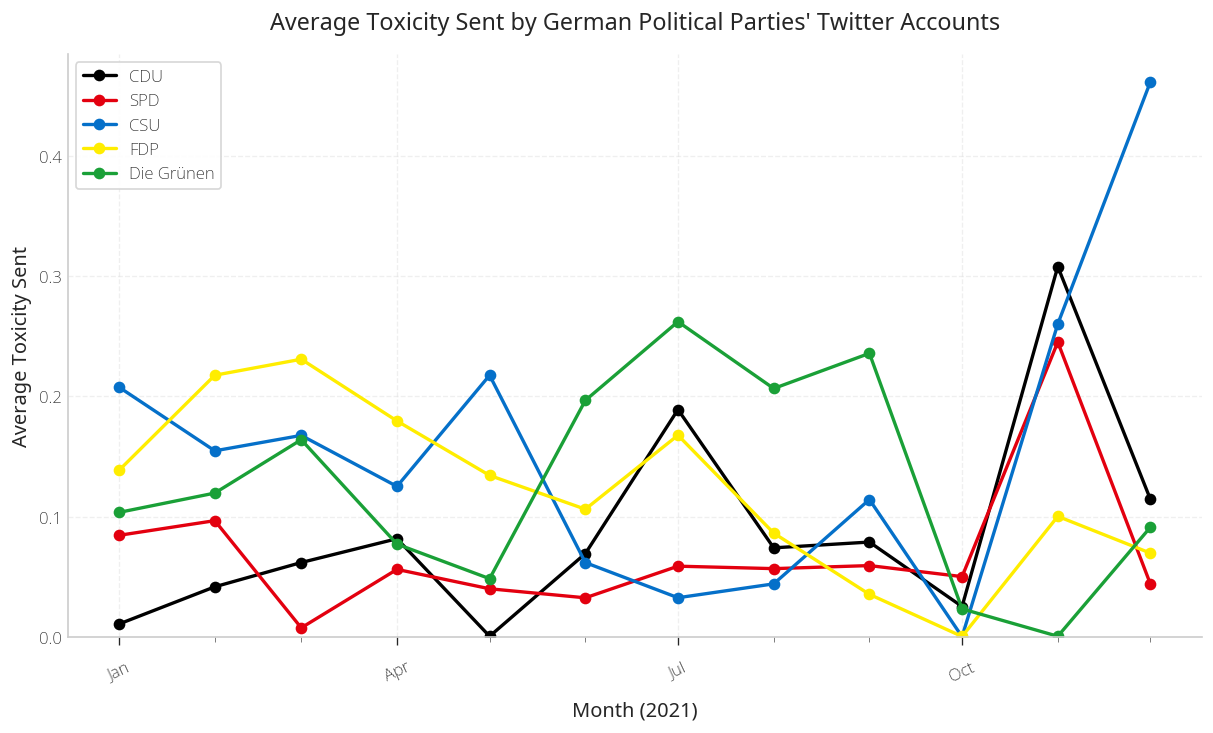

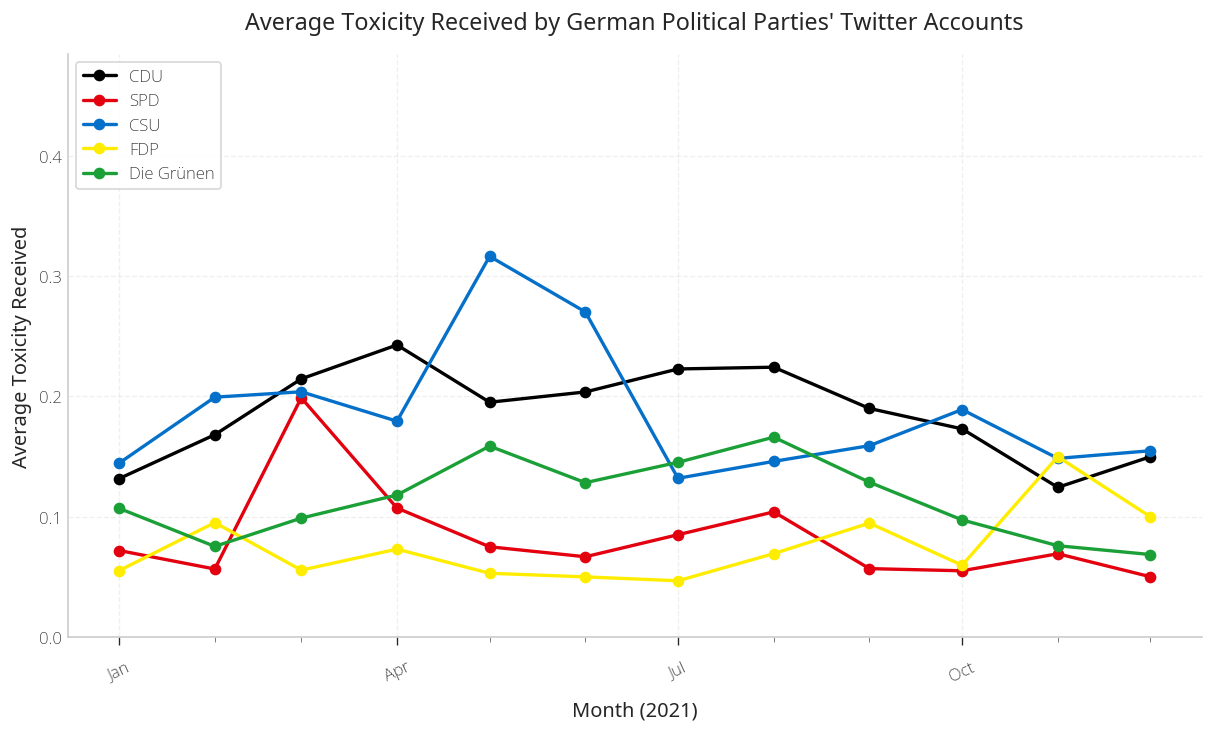

In [49]:
# Query toxicity metrics for specific German political party accounts for 2021 only
party_toxicity_query = f"""
SELECT 
    CAST(month_start AS STRING) as month_start_str,
    node_id,
    toxicity_sent_avg,
    toxicity_received_avg
FROM `grounded-nebula-408412.python_src.python_network_users_node_metrics`
WHERE node_id IN ('cdu', 'spdde', 'csu', 'fdp', 'die_gruenen')
  AND month_start >= '2021-01-01' 
  AND month_start < '2022-01-01'
ORDER BY month_start, node_id
"""

# Run the query
party_df = run_query(party_toxicity_query)

# Define colors for each party
party_colors = {
    "cdu": "#000000",  # Black for CDU
    "spdde": "#E3000F",  # Red for SPD
    "csu": "#0570C9",  # Blue for CSU
    "fdp": "#FFED00",  # Yellow for FDP
    "die_gruenen": "#1AA037",  # Green for Die Grünen
}

# Map party IDs to proper names
party_names = {
    "cdu": "CDU",
    "spdde": "SPD",
    "csu": "CSU",
    "fdp": "FDP",
    "die_gruenen": "Die Grünen",
}

# Check if we got data back
if len(party_df) == 0:
    print("No data returned from query. Check permissions and table content.")
else:
    # Check if required columns exist
    if "month_start_str" not in party_df.columns:
        print(
            f"Error: 'month_start_str' column not found. Available columns: {list(party_df.columns)}"
        )
    else:
        # Convert string date to datetime
        party_df["month_start"] = pd.to_datetime(party_df["month_start_str"])

        # Find the global maximum value for both metrics to standardize scales
        max_toxicity_sent = party_df["toxicity_sent_avg"].max()
        max_toxicity_received = party_df["toxicity_received_avg"].max()
        global_max = max(max_toxicity_sent, max_toxicity_received) * 1.05  # Add 5% margin

        # Set Noto Sans as the font style
        plt.rcParams.update({
            'font.family': 'sans-serif',
            'font.sans-serif': ['Noto Sans', 'Noto Sans Light', 'DejaVu Sans'],
            'font.size': 10,
            'font.weight': 'light',  # Default to light font weight
            'figure.dpi': 120,  # Higher DPI for better resolution
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'axes.titleweight': 'regular',  # Regular weight for title (semi-bold)
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 10,
            'figure.figsize': (10, 6),  # Adjust aspect ratio to reduce stretching
            'figure.constrained_layout.use': True,  # Better layout with less distortion
        })

        # Function to create plot with consistent styling
        def create_toxicity_plot(metric_name, y_label, title):
            fig, ax = plt.subplots()
            
            for party in ["cdu", "spdde", "csu", "fdp", "die_gruenen"]:
                party_data = party_df[party_df["node_id"] == party]
                if not party_data.empty:
                    ax.plot(
                        party_data["month_start"],
                        party_data[metric_name],
                        marker="o",
                        linewidth=2,
                        markersize=6,
                        color=party_colors.get(party),
                        label=party_names.get(party, party),
                    )
                else:
                    print(f"No data found for party: {party}")

            # Title and labels with improved typography and Noto Sans font
            ax.set_title(
                title,
                fontweight="regular",  # Regular weight for Noto Sans instead of bold
                pad=15,
                fontfamily="Noto Sans"
            )

            # x-label now set in the main function to avoid duplicate labels
            ax.set_ylabel(y_label)

            # Improved legend
            ax.legend(
                loc="upper left", 
                frameon=True, 
                framealpha=0.9, 
                edgecolor='lightgray'
            )

            # Refined grid
            ax.grid(True, linestyle="--", alpha=0.5, color='#E0E0E0')

            # Set up tick marks
            import matplotlib.dates as mdates

            # Major ticks every quarter
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

            # Minor ticks every month
            ax.xaxis.set_minor_locator(mdates.MonthLocator())

            # Move year to main x-axis label to avoid collision
            ax.set_xlabel("Month (2021)", labelpad=10)

            # Customize tick marks
            ax.tick_params(axis="x", which="minor", length=3, color="gray", bottom=True)
            ax.tick_params(axis="x", which="major", length=5, pad=8, bottom=True)
            
            # Improve y-axis appearance
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Fewer y-axis ticks
            
            # Set limits
            ax.set_ylim(0, global_max)
            
            # Increase bottom margin and rotate labels less to avoid overlap
            plt.xticks(rotation=25)
            plt.subplots_adjust(bottom=0.15)  # Add more space at the bottom
            
            # Remove unnecessary spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            return fig

        # Create toxicity sent plot
        fig_sent = create_toxicity_plot(
            "toxicity_sent_avg",
            "Average Toxicity Sent",
            "Average Toxicity Sent by German Political Parties' Twitter Accounts"
        )
        plt.show()

        # Create toxicity received plot
        fig_received = create_toxicity_plot(
            "toxicity_received_avg",
            "Average Toxicity Received",
            "Average Toxicity Received by German Political Parties' Twitter Accounts"
        )
        plt.show()